In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import plotly.graph_objects as go

import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from math import floor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc


Lectura de datos

In [2]:
data_dir = Path('data')
full_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)


In [3]:
full_df.shape

(30904308, 19)

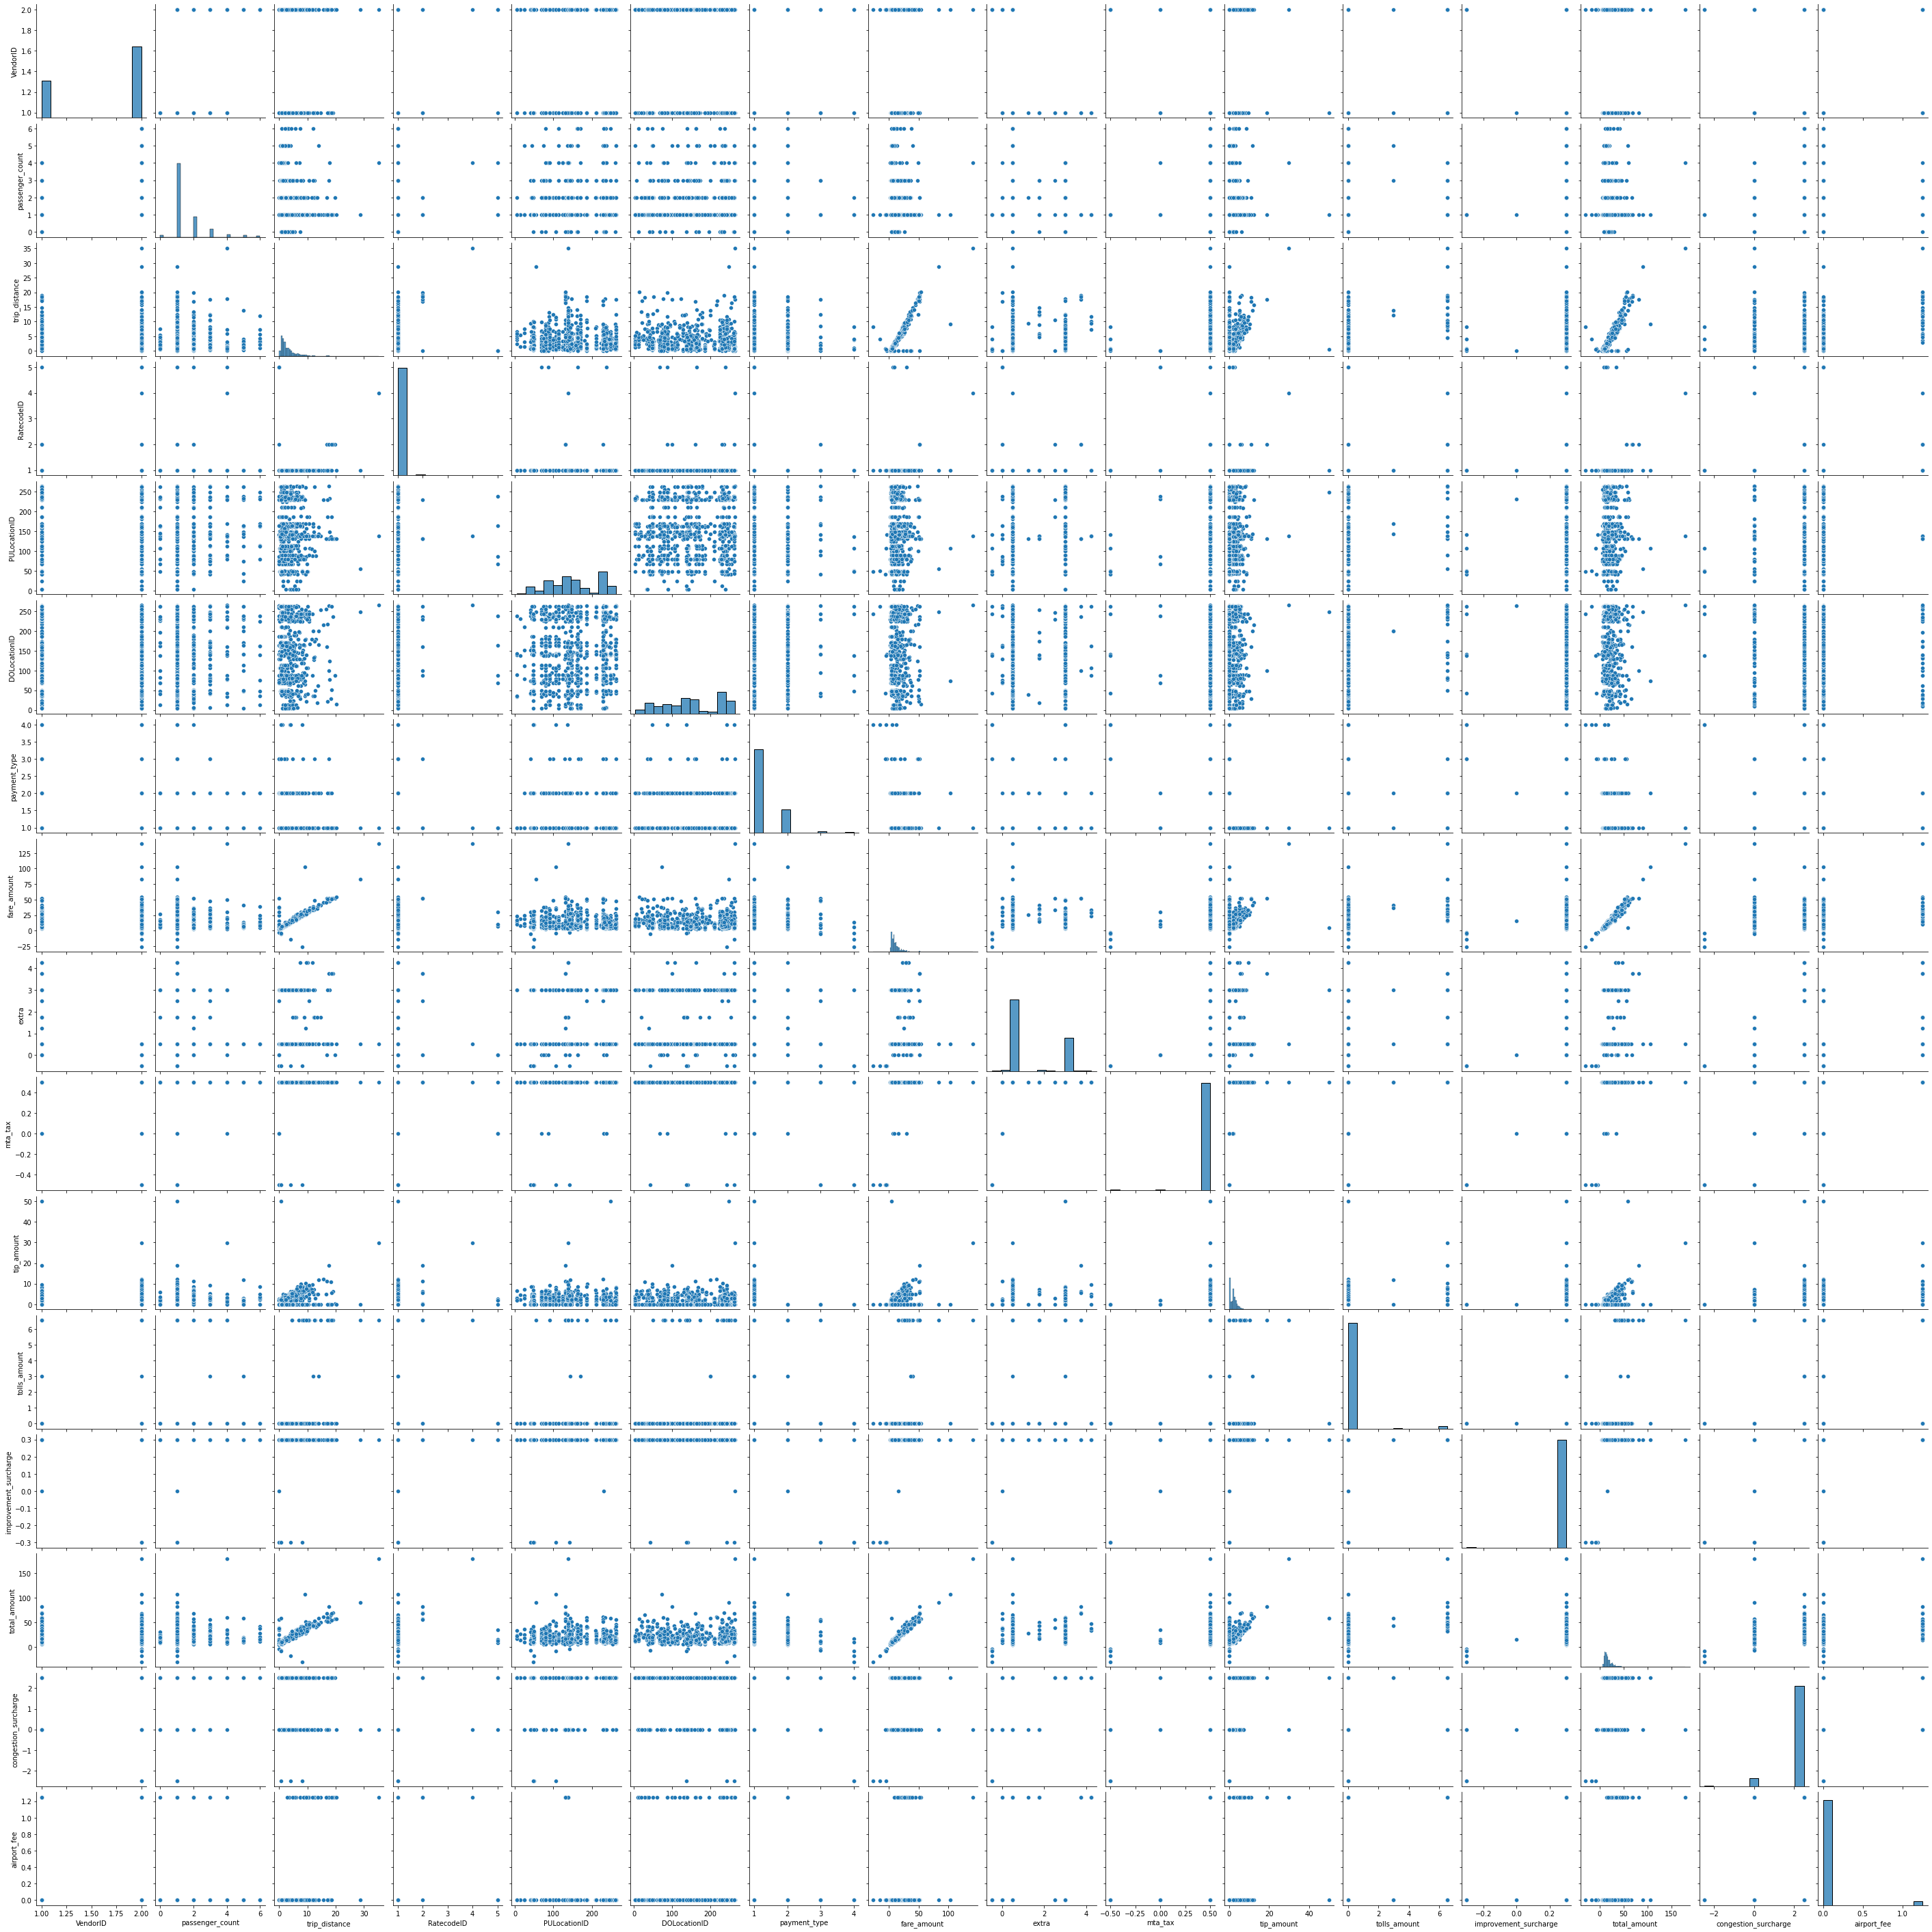

In [72]:
sns.pairplot(full_df[:1000])

In [5]:
full_df.isnull().sum()

VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count          1478695
trip_distance                  0
RatecodeID               1478695
store_and_fwd_flag       1478695
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge     1478695
airport_fee              5641418
dtype: int64

Tratamiento de valores faltantes y extremos

In [15]:
from sqlalchemy import null
import math


full_df['airport_fee'] = full_df['airport_fee'].map(lambda x: 0 if math.isnan(x) else x)
full_df['RatecodeID'] = full_df['airport_fee'].map(lambda x: 1 if x is None else x)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    full_df[['PULocationID', 'DOLocationID', 'tpep_pickup_datetime', 'trip_distance', 'RatecodeID', 'payment_type', 'airport_fee']], 
    full_df['total_amount'],  
    test_size=0.3,
    random_state=42)

X_train.shape, X_test.shape

((21633015, 7), (9271293, 7))

In [18]:
X_train.isnull().sum()

PULocationID            0
DOLocationID            0
tpep_pickup_datetime    0
trip_distance           0
RatecodeID              0
payment_type            0
airport_fee             0
dtype: int64

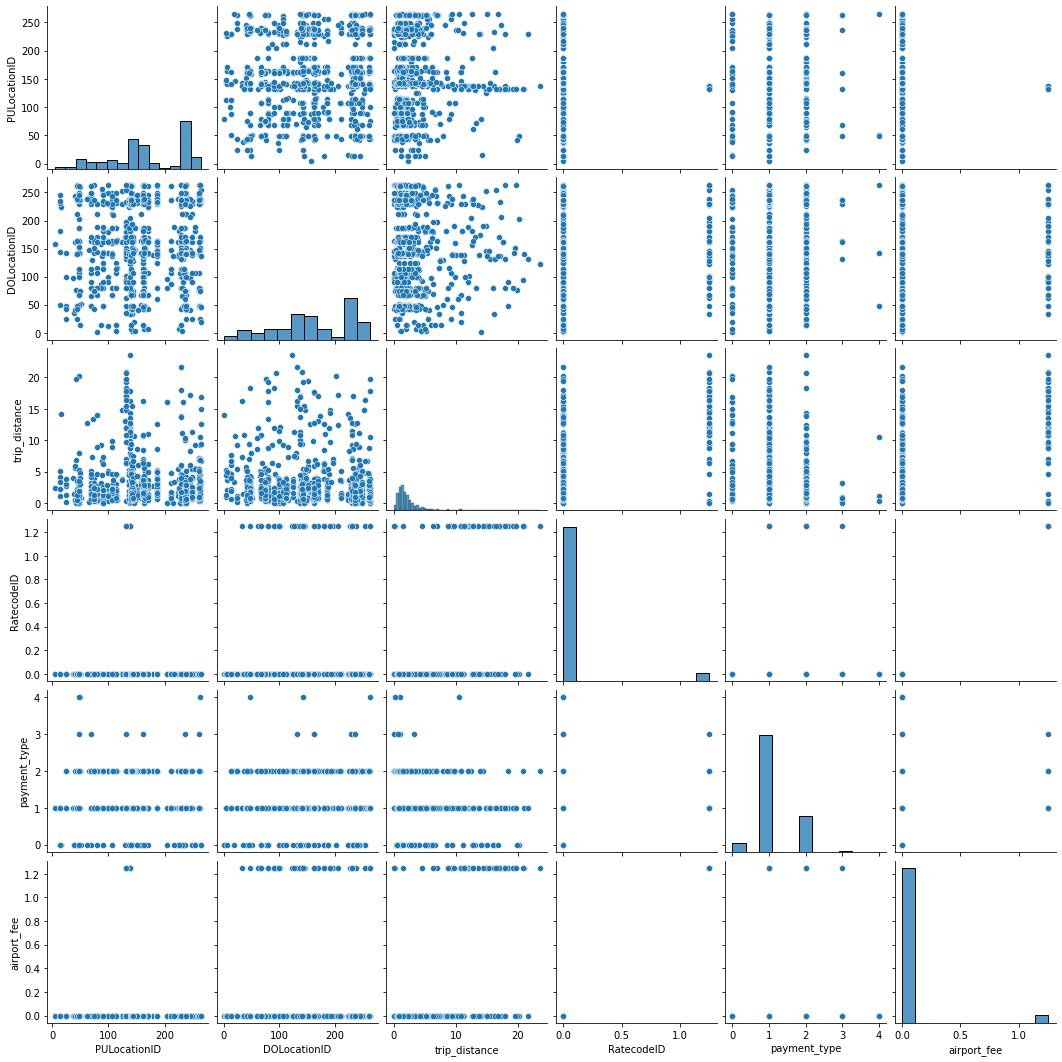

In [19]:
sns.pairplot(X_train[:1000])

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe_encoder = OneHotEncoder(categories='auto',
                           drop=None, # first/last=k-1,False = k (OHE)
                           sparse=False # No devolver una matriz esparsa
) 

ohe_encoder.fit(X_train.fillna('Missing').values)
ohe_encoder.categories_

Mapeamos datetime por hora del dia

In [20]:
full_df['pickup_hour'] = full_df['tpep_pickup_datetime'].map(lambda x: x.hour)

In [21]:
full_df.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_hour
0,1,2021-05-01 00:37:18,2021-05-01 00:41:07,2.0,0.70,0.0,N,141,263,1,5.0,3.0,0.5,2.20,0.0,0.3,11.00,2.5,0.0,0
1,1,2021-05-01 00:43:01,2021-05-01 00:49:19,1.0,1.40,0.0,N,263,75,2,6.5,3.0,0.5,0.00,0.0,0.3,10.30,2.5,0.0,0
2,1,2021-05-01 00:05:54,2021-05-01 00:31:46,1.0,5.70,0.0,N,142,129,2,21.5,3.0,0.5,0.00,0.0,0.3,25.30,2.5,0.0,0
3,2,2021-05-01 00:08:21,2021-05-01 00:19:20,1.0,3.04,0.0,N,231,97,1,11.5,0.5,0.5,3.06,0.0,0.3,18.36,2.5,0.0,0
4,2,2021-05-01 00:32:44,2021-05-01 00:48:44,1.0,4.04,0.0,N,148,17,1,15.5,0.5,0.5,5.79,0.0,0.3,25.09,2.5,0.0,0


In [ ]:
expensive_limit = 10
cheap_limit = 5

In [ ]:
full_df['segmented_amount'] = full_df['amount'].map(lambda x: 'expensive' if x > 10 else 'cheap' if x < 5 else 'medium' )

In [ ]:
full_df = pd.get_dummies(full_df, columns=['segmented_amount']) 
full_df.head(5)

In [39]:
df = full_df[full_df.total_amount < 100]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    df[['PULocationID', 'DOLocationID', 'pickup_hour', 'trip_distance', 'RatecodeID', 'payment_type', 'airport_fee']], 
    df['total_amount'],  
    test_size=0.3,
    random_state=42)

X_train.shape, X_test.shape

((21586247, 7), (9251250, 7))

In [28]:
X_train.dtypes

PULocationID       int64
DOLocationID       int64
pickup_hour        int64
trip_distance    float64
RatecodeID       float64
payment_type       int64
airport_fee      float64
dtype: object

Modelos

Random forest, linear regression model, laso o rich por overfiting

Podemos dividir el amount en caro medio barato o mas y clasificar

Quedemosnos con un medio de pago. credit card

In [45]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 23)

In [46]:
rf.fit(X_train[:1000], y_train[:1000])

RandomForestRegressor(random_state=23)

In [47]:
predictions = rf.predict(X_test)

In [33]:
# Calcular los errores absolutos
errores = abs(predictions - y_test)

# Imprime el error absoluto medio (mae)
print('Error absoluto medio:', round(np.mean(errores), 2))

Error absoluto medio: 3.03


In [42]:
df.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_hour
0,1,2021-05-01 00:37:18,2021-05-01 00:41:07,2.0,0.70,0.0,N,141,263,1,5.0,3.0,0.5,2.20,0.0,0.3,11.00,2.5,0.0,0
1,1,2021-05-01 00:43:01,2021-05-01 00:49:19,1.0,1.40,0.0,N,263,75,2,6.5,3.0,0.5,0.00,0.0,0.3,10.30,2.5,0.0,0
2,1,2021-05-01 00:05:54,2021-05-01 00:31:46,1.0,5.70,0.0,N,142,129,2,21.5,3.0,0.5,0.00,0.0,0.3,25.30,2.5,0.0,0
3,2,2021-05-01 00:08:21,2021-05-01 00:19:20,1.0,3.04,0.0,N,231,97,1,11.5,0.5,0.5,3.06,0.0,0.3,18.36,2.5,0.0,0
4,2,2021-05-01 00:32:44,2021-05-01 00:48:44,1.0,4.04,0.0,N,148,17,1,15.5,0.5,0.5,5.79,0.0,0.3,25.09,2.5,0.0,0


In [44]:
y_test

2168052     8.80
1570875    12.30
59686      21.30
2065188    42.96
660375     13.80
           ...  
1296599    12.80
2070088    25.63
1277432    27.60
266514      9.30
1332100    12.80
Name: total_amount, Length: 9251250, dtype: float64

/Users/ezefernandez/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


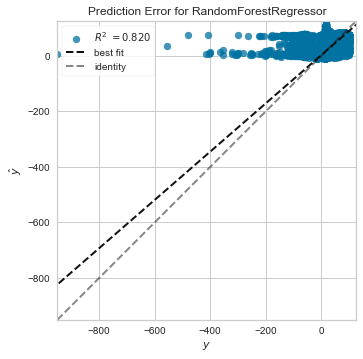

<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [41]:
from yellowbrick.regressor import PredictionError
visualizer = PredictionError(rf)
visualizer.fit(X_train[:10000], y_train[:10000]) 
visualizer.score(X_test, y_test)
visualizer.show()

In [56]:
def plotGraph(y_test,y_pred,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    plt.scatter(range(len(y_test)), y_test, color='blue')
    plt.scatter(range(len(y_pred)), y_pred, color='red')
    plt.title(regressorName + ' - red: predicted')
    plt.show()
    return

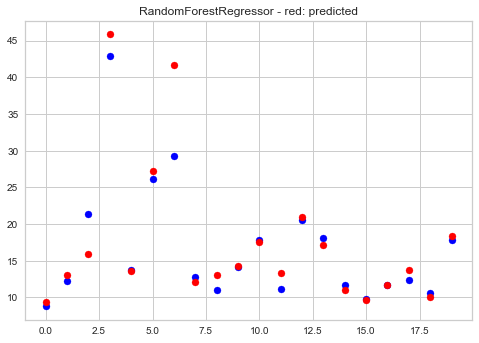

In [57]:
plotGraph(y_test[:20], predictions[:20], 'RandomForestRegressor')